<a href="https://colab.research.google.com/github/stefan-stein/NLP_with_TF_2.0/blob/master/NLP_with_TF_2_0_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are my notes for the second part of the "Natural Language Processing with Tensorflow  2 - Beginner's course" that can be found [here](https://www.youtube.com/watch?v=B2q5cRJvqI8). This course consists of three parts and the second one deals with sentiment analysis. This particular part is based on [this](https://www.tensorflow.org/tutorials/text/text_classification_rnn) official tensorflow tutorial.

# Sentiment analysis

We are still using the 'IMDB movie database' which consists of movie reviews which are labelled either as 'positive' (=1) or 'negative' (=0).
In this portion of the course we try to predict whether a review is good or bad based on the sentiment of the review. 

As before, we need to make sure we explicitly select Tensorflow 2.x.

In [1]:
%tensorflow_version 2.x
import tensorflow_datasets as tfds
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
encoder = info.features['text'].encoder

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29RZ4Q/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29RZ4Q/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete29RZ4Q/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


The encoder is currently initialized with some random weights. Let's check out how it works with a very simple example.

In [7]:
sample_string = 'Hello NLP'

encoded_string = encoder.encode(sample_string)
print("Encoded string: {}".format(encoded_string))
decoded_string = encoder.decode(encoded_string)
print("Decoded string: {}".format(decoded_string))
sample_string == decoded_string

Encoded string: [4025, 222, 8007, 8005, 8009]
Decoded string: Hello NLP


True

Alright, this seems to work. Let's go on to building the model.

As in the 'Word embeddings' portion of the course, we have to pad our movie reviews before passing them into our neural network. Using `None` in `padded_shapes` means that we take the lenght of the longest review and pad all our reviews to that length. 


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
padded_shapes = ([None], ())

train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,
                                                                padded_shapes=padded_shapes)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,
                                                              padded_shapes=padded_shapes)

Now we construct our model: We want to use a recurrent neural network that learns dependencies between words of a sentence. We first pass the our word vector into an embedding layer, which embeds the into 64-dimensional latent space. It follows the actual 'recurrent' part of the network which is implementet using a `tf.keras.layers.Bidirectional` layer. We then pass the output of that layer through a dense layer with `'relu'` activation before passing it into another dense layer with `'sigmoid'` activation, i.e. the last layer will give us the probability (or rather, the confidence) we have in the current review being positive.

We use pretty standard configurations for training, which is `'binary_crossentropy'` as loss function, `'Adam'` as optimizer and `'accuracy'` as metric.

In [9]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(encoder.vocab_size, 64),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


## Train the model!

In [11]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset,
                    validation_steps = 30)

Epoch 1/5
391/391 [==============================] - 968s 2s/step - loss: 0.6561 - accuracy: 0.6093 - val_loss: 0.4615 - val_accuracy: 0.8005
Epoch 2/5
391/391 [==============================] - 963s 2s/step - loss: 0.3587 - accuracy: 0.8549 - val_loss: 0.3411 - val_accuracy: 0.8578
Epoch 3/5
391/391 [==============================] - 966s 2s/step - loss: 0.2532 - accuracy: 0.9052 - val_loss: 0.3469 - val_accuracy: 0.8667
Epoch 4/5
391/391 [==============================] - 963s 2s/step - loss: 0.2125 - accuracy: 0.9241 - val_loss: 0.3419 - val_accuracy: 0.8687
Epoch 5/5
391/391 [==============================] - 959s 2s/step - loss: 0.1865 - accuracy: 0.9357 - val_loss: 0.3361 - val_accuracy: 0.8667


## Test the model!

We have to pad a self-written review that we want to test the model on first. Hence the following two helper functions.

In [0]:
def pad_to_size(vec, size):
  zeros = [0]*(size-len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sentence, pad=True):
  encoded_sample_pred_text = encoder.encode(sentence)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return predictions


Let's try it!

In [13]:
sample_text = ('This movie was awesome. The acting was incredible. Highly recommend.')
predictions = sample_predict(sample_text, pad=True) * 100

print('Probability this is a positive review %.2f' % predictions)


Probability this is a positive review 79.52


Ok, this works. Let's see if it also can handle more complex reviews.

In [16]:
sample_text = ('The movie started out weak and strongly declined in quality. But in total it was not as bad as initially expected.')
predictions = sample_predict(sample_text, pad=True) *100

print('Probability this is a positive review %.2f' % predictions)

Probability this is a positive review 10.56


Alright! That works, too. Now let's try a really difficult one.

In [15]:
sample_text = ('The best part were the credits.')
predictions = sample_predict(sample_text, pad=True) *100

print('Probability this is a positive review %.2f' % predictions)

Probability this is a positive review 61.05


Ok, it is kind of to be expected that it did not catch that one. Although it is a good sign that the model is not overly confident in its prediction, though (although this could also be an artifact of the sentence being very short...).

## Save the model

Training took a pretty long time even though we were running in the training colab. So let's make sure we don't lose our trained model.

In [17]:
model.save('sentimentModel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: sentimentModel/assets


INFO:tensorflow:Assets written to: sentimentModel/assets


Did it work?

In [0]:
new_model = tf.keras.models.load_model('sentimentModel')

In [19]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


Very good!

## Visualisations

Finally, let's make some pretty graphs. Given the training history of a model and a metric of interest, we create a matplotlib plot showing how the metric evolves over time.

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

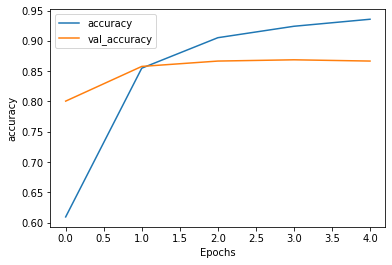

In [21]:
plot_graphs(history, 'accuracy')

Training accuracy increases steadily, while validation accuracy flattens out after some time, which is the picture we would expect.

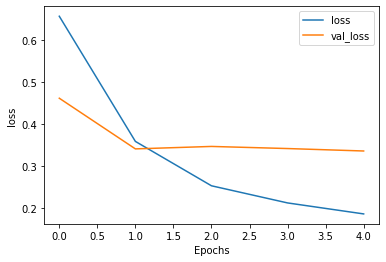

In [22]:
plot_graphs(history, 'loss')

The 'inverse' picture to the plot above: Training loss decreases steadily while validation loss flattens out after some time.